<span style="font-size: 20px;">**Setting**</span>

In [1]:
import os
# GPU 설정
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3, 4, 5"

import torch
import torch.nn as nn
import numpy as np
import glob
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ToTensor, Resize, Normalize

from torch.utils.data import Dataset, DataLoader

import monai
from monai.data import DataLoader, ArrayDataset
from monai.transforms import (
    LoadImage, 
    EnsureChannelFirst,  # AddChannel 대신 EnsureChannelFirst 사용
    Resize,
    NormalizeIntensity,
    Transform,
    ToTensor,
    Compose
)


<span style="font-size: 20px;">**Setup data directory**</span>

In [2]:
# <Setup data directory>
# 기본 경로 설정
root_dir = "/home/aix23107/U-noise/T1"
print(root_dir)

# 데이터 라벨링을 위한 CSV 파일 경로 설정
csv_path = os.path.join(root_dir, "filtered_healthy_data.csv")

# CSV 파일 로드
df = pd.read_csv(csv_path, dtype={'ID': str})

# NIfTI 파일 경로 설정 및 불러오기 (root_dir와 동일)
t1w_dir = root_dir
nii_files = sorted(glob.glob(os.path.join(t1w_dir, "*.nii")))

# 파일 개수 확인
nii_file_count = len(nii_files)
print(f"Number of NIfTI files in T1w directory: {nii_file_count}")


/home/aix23107/U-noise/T1
Number of NIfTI files in T1w directory: 37283


<span style="font-size: 20px;">**Data Shape**</span>

Image shape: (182, 218, 182)


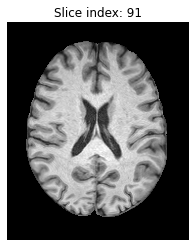

In [3]:
# <Data Shape>
import nibabel as nib

# 첫 번째 이미지 로드 및 시각화
first_nii_path = nii_files[0]
nii_image = nib.load(first_nii_path)
image_data = nii_image.get_fdata()

# 이미지 데이터 shape 출력
print(f"Image shape: {image_data.shape}")

# 중앙 axial 슬라이스 시각화
slice_index = image_data.shape[2] // 2  # 중앙 슬라이스
plt.imshow(image_data[:, :, slice_index].T, cmap="gray", origin="lower")
plt.axis("off")
plt.title(f"Slice index: {slice_index}")
plt.show()


<span style="font-size: 20px;">**Age & Sex Labeling**</span>

In [4]:
#라벨 데이터 설정 (나이와 성별)
sexes = df['Sex'].values
ages = df['Age'].values
labels = df[['Age', 'Sex']].values

# 파일과 라벨 개수 확인
print(f"Number of NIfTI files: {len(nii_files)}")
print(f"Number of labels (sexes, ages): {len(sexes)}, {len(ages)}")

Number of NIfTI files: 37283
Number of labels (sexes, ages): 37283, 37283


<span style="font-size: 20px;">**Transform**</span>

In [5]:
# 사용자 정의 Transform 클래스 (Divide by Mean)
class DivideByMean(Transform):
    def __call__(self, data):
        return data / data.mean()

# MONAI Transform 정의 (이미지 전처리)
imtrans = Compose(
    [
        LoadImage(image_only=True),             # NIfTI 파일 로드
        EnsureChannelFirst(),                   # 채널을 첫 번째로 배치
        Resize(spatial_size=(140, 176, 140)),   # 이미지 크기 조정
        DivideByMean(),                         # 이미지의 평균으로 나누기 (정규화)
        ToTensor()                              # 텐서로 변환
    ]
)

<span style="font-size: 20px;">**Dataset**</span>

In [6]:
# 여성 데이터 필터링 (Sex 값이 0인 경우)
male_indices = df[df['Sex'] == 1].index
male_files = [nii_files[i] for i in male_indices]
male_labels = df.loc[male_indices, ['Age', 'Sex']].values

# 파일과 라벨 개수 확인
print(f"Number of female NIfTI files: {len(male_files)}")
print(f"Number of female labels (ages, sexes): {len(male_labels)}")


Number of female NIfTI files: 17653
Number of female labels (ages, sexes): 17653


In [7]:
# 라벨 Transform (PyTorch 텐서로 변환)
label_trans = Compose([ToTensor()])

# ArrayDataset을 사용하여 여성 데이터셋 구성
dataset = ArrayDataset(
    male_files,   # 여성 이미지 파일 경로 리스트
    imtrans,        # 이미지에 적용할 Transform
    male_labels,  # 여성 라벨 리스트
    label_trans     # 라벨에 적용할 Transform
)

# 데이터셋의 크기 확인
print(f"Total number of male images in the dataset: {len(dataset)}")


Total number of male images in the dataset: 17653


In [8]:
# 데이터셋에서 첫 번째 데이터 샘플 불러오기
sample_idx = 0
image, label = dataset[sample_idx]

# 데이터가 정상적으로 로드되었는지 확인
if image is not None and label is not None:
    # 이미지와 라벨 정보 확인
    print(f"Sample Image Shape: {image.shape}")  # 이미지의 shape 출력
    print(f"Sample Label (Age, Sex): {label}")   # 라벨 출력
else:
    print("Failed to load the sample data.")

Sample Image Shape: torch.Size([1, 140, 176, 140])
Sample Label (Age, Sex): tensor([69,  1])


<span style="font-size: 20px;">**Visualize**</span>

Sample Image Shape: torch.Size([1, 140, 176, 140])
Sample Label (Age, Sex): tensor([69,  1])


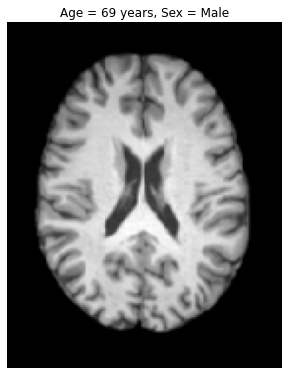

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋에서 첫 번째 데이터 샘플 불러오기
sample_idx = 0
image, label = dataset[sample_idx]

# 데이터가 정상적으로 로드되었는지 확인
if image is not None and label is not None:
    # 이미지와 라벨 정보 확인
    print(f"Sample Image Shape: {image.shape}")  # 이미지의 shape 출력
    print(f"Sample Label (Age, Sex): {label}")   # 라벨 출력
    
    # 첫 번째 이미지의 슬라이스 시각화 (중앙 슬라이스 선택)
    middle_slice_idx = image.shape[-1] // 2  # 깊이 방향에서 중앙 슬라이스 인덱스
    image_slice = image[0, :, :, middle_slice_idx].detach().cpu().numpy()  # 이미지 슬라이스 (채널 제외)

    # 시각화
    fig = plt.figure("Example image for training", (12, 6))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    # 제목에 나이와 성별을 포함하여 설정
    age = label[0].item()  # 나이 정보
    sex = label[1].item()  # 성별 정보
    sex_text = 'Female' if sex == 0 else 'Male'
    ax.set_title(f"Age = {age} years, Sex = {sex_text}")

    # 이미지 시각화
    ax.imshow(np.rot90(image_slice), cmap="gray")
    ax.axis('off')

    # 시각화 출력
    plt.show()
else:
    print("Failed to load the sample data.")


<span style="font-size: 20px;">**DataLoader & Data Split**</span>

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset


# 전체 남성 데이터셋의 인덱스 생성
total_indices = list(range(len(dataset)))

# train, temp (val + test) 분할
train_indices, temp_indices = train_test_split(total_indices, test_size=0.3, random_state=42)

# temp를 다시 validation과 test로 나누기
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

# 데이터셋 분할에 따른 정보 출력
print(f"Number of training samples: {len(train_indices)}")
print(f"Number of validation samples: {len(val_indices)}")
print(f"Number of test samples: {len(test_indices)}")

# Subset을 사용하여 train, val, test 데이터셋 생성
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)


batch_size = 8

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


# Step 6: 데이터 로더에서 첫 번째 배치 데이터 확인
train_iter = iter(train_loader)
images, labels = next(train_iter)  # 첫 번째 배치 가져오기



# 첫 번째 배치의 이미지와 라벨 shape 확인
print(f"Batch Image Shape: {images.shape}")  # 배치 이미지의 shape 출력
print(f"Batch Label Shape: {labels.shape}")  # 배치 라벨의 shape 출력


Number of training samples: 12357
Number of validation samples: 2648
Number of test samples: 2648
Batch Image Shape: torch.Size([8, 1, 140, 176, 140])
Batch Label Shape: torch.Size([8, 2])


<span style="font-size: 20px;">**Model(3D CNN)**</span>

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GAP_3DCNN(nn.Module):
    def __init__(self, output_dim=1):
        super(GAP_3DCNN, self).__init__()
        # 기존 3D-CNN 부분
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv3d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv3d(256, 64, kernel_size=1, stride=1, padding=0)  # 채널 수 축소

        # Global Average Pooling (GAP) 레이어
        self.gap = nn.AdaptiveAvgPool3d(1)
        
        # BatchNorm layers
        self.bn1 = nn.BatchNorm3d(32)
        self.bn2 = nn.BatchNorm3d(64)
        self.bn3 = nn.BatchNorm3d(128)
        self.bn4 = nn.BatchNorm3d(256)
        self.bn5 = nn.BatchNorm3d(256)
        self.bn6 = nn.BatchNorm3d(64)

        # 성별 정보를 위한 Fully Connected layer
        self.fc_sex = nn.Linear(1, 8)  # 성별 입력을 8차원으로 확장

        # 이미지 특징과 성별 정보를 결합한 후의 Fully Connected layer
        self.fc_final = nn.Linear(64 + 8, output_dim)  # 이미지 특징(64) + 성별 정보(8)

    def forward(self, x, sex):
        # 이미지 특징 추출 부분
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool3d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool3d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool3d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool3d(x, 2)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool3d(x, 2)
        x = F.relu(self.bn6(self.conv6(x)))

        # Global Average Pooling 적용
        x = self.gap(x)
        x = torch.flatten(x, 1)  # [batch_size, 64]

        # 성별 정보를 FC 레이어를 통해 차원 확장
        sex = sex.view(-1, 1)  # 성별 정보를 [batch_size, 1] 형태로 변환
        sex_features = F.relu(self.fc_sex(sex))  # [batch_size, 8]

        # 이미지 특징과 성별 특징 결합
        combined = torch.cat((x, sex_features), dim=1)  # [batch_size, 64 + 8]

        # 최종 예측
        output = self.fc_final(combined)  # [batch_size, output_dim]
        return output


<span style="font-size: 20px;">**GPU setting & Optimizer & Loss function**</span>

In [12]:
# 모델 및 학습 설정
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


# GPU 사용 가능 여부에 따른 device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 정의
model = GAP_3DCNN().to(device)

# 여러 GPU 사용 설정
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

# Optimizer 및 학습률 스케줄러 설정
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # 학습률 조정 (0.001로 낮춤)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# L1 손실 함수 사용
criterion = nn.L1Loss()


<span style="font-size: 20px;">**Train&Validation(BA)**</span>

In [20]:
from tqdm import tqdm

# 모델 학습
num_epochs = 30
best_val_loss = float('inf')
best_model_path = "/home/aix23107/U-noise/best_brain_age_model_male_v1.pth"

train_losses = []  # Train loss 저장 리스트
val_losses = []    # Validation loss 저장 리스트

early_stopping_patience = 10  # Early Stopping 기준
early_stopping_counter = 0  # Early Stopping 카운터

for epoch in range(num_epochs):
    # Training 단계
    model.train()
    running_loss = 0.0

    # tqdm을 사용해 학습 진행 시각화 (leave=False 추가)
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)

    for images, labels in train_loader_tqdm:
        images = images.to(device)
        age_labels = labels[:, 0].to(device).float()  # 나이 정보를 Float으로 변환
        sex_labels = labels[:, 1].unsqueeze(1).to(device).float()  # 성별 정보를 Float으로 변환

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images, sex_labels)
        loss = criterion(outputs.squeeze(), age_labels)

        # Backward pass 및 최적화
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)  # Train loss 저장
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    # Validation 단계
    model.eval()
    val_loss = 0.0

    # tqdm을 사용해 검증 진행 시각화 (leave=False 추가)
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False)

    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images = images.to(device)
            age_labels = labels[:, 0].to(device).float()  # 나이 정보를 Float으로 변환
            sex_labels = labels[:, 1].unsqueeze(1).to(device).float()  # 성별 정보를 Float으로 변환

            # Forward pass
            outputs = model(images, sex_labels)
            loss = criterion(outputs.squeeze(), age_labels)

            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)  # Validation loss 저장
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

    # 최상의 모델 가중치 저장 및 프린트문 추가
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch [{epoch+1}] with Validation Loss: {val_loss:.4f}")
        early_stopping_counter = 0  # 성능 향상이 있을 경우 초기화
    else:
        early_stopping_counter += 1

    # Early Stopping 조건
    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping at epoch [{epoch+1}]")
        break

    # 학습률 스케줄러 업데이트 (val_loss를 전달하여 업데이트)
    scheduler.step(val_loss)


Epoch [1/30], Training Loss: 10.7032


Epoch [1/30], Validation Loss: 9.6107
Best model saved at epoch [1] with Validation Loss: 9.6107


Epoch [2/30], Training Loss: 4.8735


Epoch [2/30], Validation Loss: 5.7063
Best model saved at epoch [2] with Validation Loss: 5.7063


Epoch [3/30], Training Loss: 4.1581


Epoch [3/30], Validation Loss: 4.0754
Best model saved at epoch [3] with Validation Loss: 4.0754


Epoch [4/30], Training Loss: 3.8284


Epoch [4/30], Validation Loss: 3.7121
Best model saved at epoch [4] with Validation Loss: 3.7121


Epoch [5/30], Training Loss: 3.6090


Epoch [5/30], Validation Loss: 5.0729


Epoch [6/30], Training Loss: 3.3527


Epoch [6/30], Validation Loss: 6.7839


Epoch [7/30], Training Loss: 3.2105


Epoch [7/30], Validation Loss: 5.2781


Epoch [8/30], Training Loss: 3.0512


Epoch [8/30], Validation Loss: 4.7088
Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.


Epoch [9/30], Training Loss: 2.7288


Epoch [9/30], Validation Loss: 2.9222
Best model saved at epoch [9] with Validation Loss: 2.9222


Epoch [10/30], Training Loss: 2.6017


Epoch [10/30], Validation Loss: 2.9286


Epoch [11/30], Training Loss: 2.5279


Epoch [11/30], Validation Loss: 3.3197


Epoch [12/30], Training Loss: 2.4445


Epoch [12/30], Validation Loss: 4.4544


Epoch [13/30], Training Loss: 2.3751


Epoch [13/30], Validation Loss: 3.4566
Epoch 00013: reducing learning rate of group 0 to 2.5000e-04.


Epoch [14/30], Training Loss: 2.0823


Epoch [14/30], Validation Loss: 5.0964


Epoch [15/30], Training Loss: 2.0107


Epoch [15/30], Validation Loss: 2.8389
Best model saved at epoch [15] with Validation Loss: 2.8389


Epoch [16/30], Training Loss: 1.8972


Epoch [16/30], Validation Loss: 3.1976


Epoch [17/30], Training Loss: 1.8347


Epoch [17/30], Validation Loss: 2.8115
Best model saved at epoch [17] with Validation Loss: 2.8115


Epoch [18/30], Training Loss: 1.7658


Epoch [18/30], Validation Loss: 4.3000


Epoch [19/30], Training Loss: 1.7468


Epoch [19/30], Validation Loss: 3.6341


Epoch [20/30], Training Loss: 1.6554


Epoch [20/30], Validation Loss: 2.9373


Epoch [21/30], Training Loss: 1.6281


Epoch [21/30], Validation Loss: 2.9219
Epoch 00021: reducing learning rate of group 0 to 1.2500e-04.


Epoch [22/30], Training Loss: 1.4037


Epoch [22/30], Validation Loss: 3.7625


Epoch [23/30], Training Loss: 1.2993


Epoch [23/30], Validation Loss: 2.9109


Epoch [24/30], Training Loss: 1.2488


Epoch [24/30], Validation Loss: 2.8269


Epoch [25/30], Training Loss: 1.2006


Epoch [25/30], Validation Loss: 3.5266
Epoch 00025: reducing learning rate of group 0 to 6.2500e-05.


Epoch [26/30], Training Loss: 1.0460


Epoch [26/30], Validation Loss: 2.8658


Epoch [27/30], Training Loss: 0.9971


Epoch [27/30], Validation Loss: 2.7537
Best model saved at epoch [27] with Validation Loss: 2.7537


Epoch [28/30], Training Loss: 0.9356


Epoch [28/30], Validation Loss: 2.7995


Epoch [29/30], Training Loss: 0.9043


Epoch [29/30], Validation Loss: 2.7983


Epoch [30/30], Training Loss: 0.8751


Epoch [30/30], Validation Loss: 2.8165


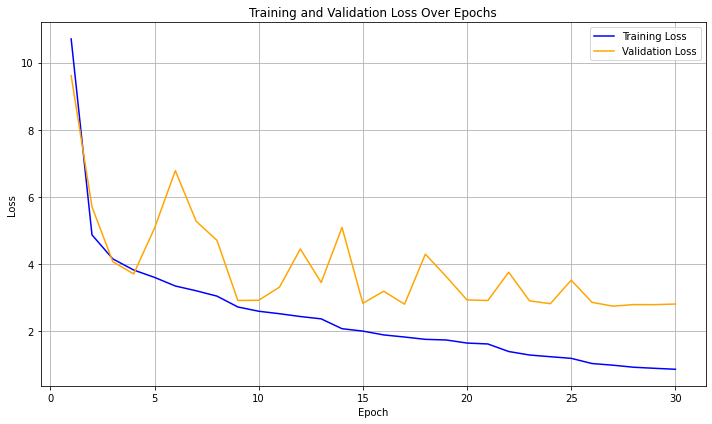

In [21]:
import matplotlib.pyplot as plt

# 에폭 수에 따른 손실 변화 시각화
plt.figure(figsize=(10, 6))

# Train Loss 플롯
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')

# Validation Loss 플롯
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')

# 플롯 설정
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()

# 그래프 출력
plt.show()


<span style="font-size: 20px;">**Test(BA)**</span>

In [13]:
from tqdm import tqdm
import torch
import torch.nn as nn

# 베스트 모델 불러오기
best_model_path = "/home/aix23107/U-noise/best_brain_age_model_male_v1.pth"
model.load_state_dict(torch.load(best_model_path))
model.eval()


# 테스트 단계에서 GPU 사용 설정
model.to(device)

# 손실 함수 정의 (MAE를 위해 L1 Loss 사용)
mae_criterion = nn.L1Loss()

# 테스트 데이터셋에 대한 예측 및 실제 값 저장
actual_ages = []
predicted_ages = []

# 모델을 테스트 데이터에 사용하여 예측 수행
test_loader_tqdm = tqdm(test_loader, desc="Testing Model")

with torch.no_grad():
    for images, labels in test_loader_tqdm:
        images = images.to(device)
        age_labels = labels[:, 0].to(device).float()
        sex_labels = labels[:, 1].unsqueeze(1).to(device).float()

        # 예측 수행
        outputs = model(images, sex_labels)

        # 예측된 값과 실제 값을 리스트에 저장
        predicted_ages_batch = outputs.view(-1).cpu().numpy()  # 차원을 일관성 있게 유지
        actual_ages_batch = age_labels.view(-1).cpu().numpy()  # 차원을 일관성 있게 유지

        # 예측 및 실제 값 저장
        predicted_ages.extend(predicted_ages_batch)
        actual_ages.extend(actual_ages_batch)

# 전체 테스트 데이터셋에 대한 평균 절대 오차 (MAE) 계산
predicted_ages_tensor = torch.tensor(predicted_ages)
actual_ages_tensor = torch.tensor(actual_ages)

mae = mae_criterion(predicted_ages_tensor, actual_ages_tensor)
print(f"Mean Absolute Error (MAE) on Test Set: {mae:.4f}")

Testing Model: 100%|██████████| 331/331 [02:27<00:00,  2.24it/s]

Mean Absolute Error (MAE) on Test Set: 2.7193


In [14]:
from sklearn.metrics import r2_score

# MAE와 R^2 계산
predicted_ages_tensor = torch.tensor(predicted_ages)
actual_ages_tensor = torch.tensor(actual_ages)

mae = mae_criterion(predicted_ages_tensor, actual_ages_tensor)
r2 = r2_score(actual_ages, predicted_ages)  # numpy 배열 또는 리스트 사용 가능

print(f"Mean Absolute Error (MAE) on Test Set: {mae:.4f}")
print(f"R^2 Score on Test Set: {r2:.4f}")


Mean Absolute Error (MAE) on Test Set: 2.7193
R^2 Score on Test Set: 0.8150


<span style="font-size: 20px;">**Test MAE Plot**</span>

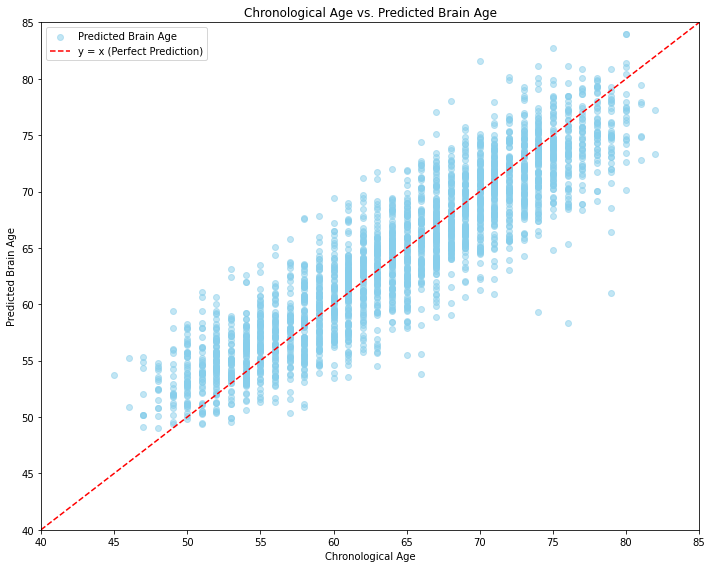

In [16]:
# 플롯 생성
plt.figure(figsize=(10, 8))

# 산점도 생성
plt.scatter(actual_ages, predicted_ages, alpha=0.5, label="Predicted Brain Age", color='skyblue')

# y=x 직선 그래프 추가
plt.plot([40, 85], [40, 85], linestyle='--', color='red', label='y = x (Perfect Prediction)')

# 플롯 설정
plt.xlim(40, 85)  # x축 범위 설정
plt.ylim(40, 85)  # y축 범위 설정
plt.xlabel("Chronological Age")
plt.ylabel("Predicted Brain Age")
plt.title("Chronological Age vs. Predicted Brain Age")
plt.legend()
plt.tight_layout()

# 그래프 출력
plt.show()


<span style="font-size: 20px;">**Grad-CAM**</span>

In [17]:
import torch
import numpy as np
from tqdm import tqdm

# Grad-CAM 구현
class GradCAM:
    def __init__(self, model, target_layer_names):
        self.model = model
        self.target_layer_names = target_layer_names
        self.feature = None
        self.gradient = None
        self.hook_layers()

    # Forward 및 Backward hook 설정
    def hook_layers(self):
        def forward_hook(module, input, output):
            self.feature = output
        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0]

        for name, module in self.model.named_modules():
            if name in self.target_layer_names:
                module.register_forward_hook(forward_hook)
                module.register_backward_hook(backward_hook)

    # Grad-CAM 맵 생성 함수
    def generate_cam(self, input_image, sex, target_class):
        self.model.zero_grad()

        # Forward pass (성별 정보와 함께)
        output = self.model(input_image, sex)

        # 타겟 클래스에 대한 Loss 계산 및 Backward pass
        class_loss = output[0, target_class]
        class_loss.backward()

        # gradient와 feature 맵 가져오기
        gradient = self.gradient.cpu().data.numpy()[0]
        feature = self.feature.cpu().data.numpy()[0]

        # 가중치 계산
        weights = np.mean(gradient, axis=(1, 2, 3))
        cam = np.zeros(feature.shape[1:], dtype=np.float32)

        # 가중치를 사용해 feature 맵을 결합
        for i, w in enumerate(weights):
            cam += w * feature[i, :, :, :]

        # ReLU 적용 (0보다 작은 값은 0으로)
        cam = np.maximum(cam, 0)

        # 정규화
        cam = cam / np.max(cam)
        return cam

# 모델의 conv5 레이어를 타겟으로 Grad-CAM 적용
model.eval()
target_layer_name = 'module.conv5'
grad_cam = GradCAM(model, [target_layer_name])

In [18]:
# 베스트 모델 가중치 불러오기
best_model_path = "/home/aix23107/U-noise/best_brain_age_model_male_v1.pth"
model.load_state_dict(torch.load(best_model_path))
model.eval()  # 모델을 평가 모드로 설정

# Grad-CAM 맵을 저장할 변수
cumulative_cam = None
count = 0

# 배치 단위로 test_loader에서 Grad-CAM 계산 및 누적
test_loader_tqdm = tqdm(test_loader, desc="Generating Grad-CAM")

for images, labels in test_loader_tqdm:
    images = images.to(device)
    sex_labels = labels[:, 1].unsqueeze(1).to(device).float()  # 성별 정보도 함께 전달

    for i in range(images.size(0)):  # 배치 내 각 이미지에 대해 처리
        image = images[i:i+1]  # 배치에서 하나의 이미지 선택
        sex = sex_labels[i:i+1]  # 해당 이미지의 성별 정보 선택

        # 타겟 클래스는 0으로 설정
        cam_map = grad_cam.generate_cam(image, sex, target_class=0)  # 성별 정보도 함께 전달
        
        # 처음 누적할 때 크기 설정
        if cumulative_cam is None:
            cumulative_cam = np.zeros_like(cam_map)

        # Grad-CAM 맵 누적
        cumulative_cam += cam_map
        count += 1

# 전체 테스트 데이터에 대한 평균 Grad-CAM 맵 계산
average_cam = cumulative_cam / count

# 결과를 numpy 파일로 저장
output_path = "/home/aix23107/U-noise/average_grad_cam_map_male.npy"
np.save(output_path, average_cam)

print(f"Average Grad-CAM map saved at: {output_path}")

Generating Grad-CAM:   0%|          | 0/331 [00:00<?, ?it/s]/home/aix23107/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Generating Grad-CAM:   2%|▏         | 8/331 [00:06<04:40,  1.15it/s]


KeyboardInterrupt: 

In [26]:
torch.cuda.empty_cache()

In [19]:
from nilearn import plotting
from nilearn.datasets import load_mni152_template
import nibabel as nib

# MNI152 템플릿 로드
mni_template = load_mni152_template()

# MNI152 템플릿의 shape 확인
mni_shape = mni_template.shape
print(f"MNI152 template shape: {mni_shape}")

# 저장된 Grad-CAM numpy 파일 로드
grad_cam_path = "/home/aix23107/U-noise/average_grad_cam_map_male.npy"
grad_cam_map = np.load(grad_cam_path)

# Grad-CAM numpy 파일의 shape 확인
grad_cam_shape = grad_cam_map.shape
print(f"Grad-CAM numpy shape: {grad_cam_shape}")


# 시각화 - 축 방향 변경 및 슬라이스 수 조정
'''plotting.plot_anat(mni_template, display_mode='z', title='MNI152 Template - Axial View', cut_coords=5)
plotting.plot_anat(mni_template, display_mode='y', title='MNI152 Template - Coronal View', cut_coords=5)
plotting.plot_anat(mni_template, display_mode='x', title='MNI152 Template - Sagittal View', cut_coords=5)

plotting.show()
'''

MNI152 template shape: (197, 233, 189)
Grad-CAM numpy shape: (8, 11, 8)


"plotting.plot_anat(mni_template, display_mode='z', title='MNI152 Template - Axial View', cut_coords=5)\nplotting.plot_anat(mni_template, display_mode='y', title='MNI152 Template - Coronal View', cut_coords=5)\nplotting.plot_anat(mni_template, display_mode='x', title='MNI152 Template - Sagittal View', cut_coords=5)\n\nplotting.show()\n"

Resampled Grad-CAM shape: (197, 233, 189)


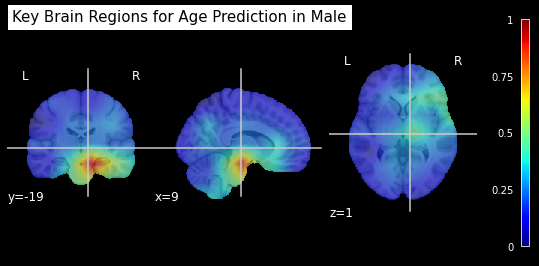

In [20]:
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom
from nilearn import plotting
from nilearn.datasets import load_mni152_template

# 저장된 Grad-CAM numpy 파일 로드
grad_cam_path = "/home/aix23107/U-noise/average_grad_cam_map_male.npy"
grad_cam_map = np.load(grad_cam_path)

# MNI152 템플릿 로드
mni_template = load_mni152_template()

# Grad-CAM numpy 맵을 MNI152 템플릿 크기로 리샘플링
zoom_factors = np.array(mni_template.shape) / np.array(grad_cam_map.shape)
resampled_grad_cam_map = zoom(grad_cam_map, zoom_factors, order=1)  # 1차 보간으로 리샘플링

# MNI152 템플릿에서 뇌 영역만 남기는 마스크 생성
brain_mask = mni_template.get_fdata() > 0  # 템플릿에서 0이 아닌 값만 남김 (뇌 영역만 남음)

# 마스크 바깥의 값 제거 (뇌 영역 외부는 0으로 설정)
resampled_grad_cam_map[~brain_mask] = 0

# 마스크 내부의 값들만 정규화
masked_grad_cam_values = resampled_grad_cam_map[brain_mask]

# 마스크 내부의 최대값과 최소값을 이용한 정규화
min_val = np.min(masked_grad_cam_values)
max_val = np.max(masked_grad_cam_values)

# 마스크 내부 값들을 정규화
if max_val != min_val:
    normalized_values = (masked_grad_cam_values - min_val) / (max_val - min_val)
    resampled_grad_cam_map[brain_mask] = normalized_values  # 정규화된 값 다시 적용

# 리샘플링된 Grad-CAM 맵을 NIfTI 이미지로 변환
resampled_grad_cam_nifti = nib.Nifti1Image(resampled_grad_cam_map, affine=mni_template.affine)

# 리샘플링된 Grad-CAM 맵의 shape 확인
print(f"Resampled Grad-CAM shape: {resampled_grad_cam_map.shape}")

# Grad-CAM 맵을 MNI152 템플릿 위에 오버레이하고, 컬러바 범위를 0부터 1로 설정 (threshold=0 설정)
plotting.plot_stat_map(
    resampled_grad_cam_nifti, 
    bg_img=mni_template, 
    title="Key Brain Regions for Age Prediction in Male", 
    cmap='jet', 
    alpha=0.5, 
    vmin=0, 
    vmax=1, 
    threshold=0  # 0 값을 시각화하기 위해 threshold를 0으로 설정
)

# 시각화 출력
plotting.show()
